<a href="https://colab.research.google.com/github/techwithlik/LoanPrediction/blob/main/Copy_of_Analysis_Loan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, KBinsDiscretizer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import ExtraTreesClassifier
from imblearn.over_sampling import RandomOverSampler

In [46]:
employment_length_mapping = {
    'Unemployed': 0,
    '< 1 year': 0.5,
    '1-4 years': 2.5,
    '4-7 years': 5.5,
    '>= 7 years': 7
}

employment_mapping = {
    'Experienced professionals': 2,
    'Professionals': 1,
    'Unskilled': 0,
    'Unemployed': -1
}

savings_balance_dict = {
    'Unknown/No savings account': 0,
    '< 80 GBP': 40,
    '80 - 400 GBP': 240,
    '400 - 800 GBP': 600,
    '>= 800 GBP': 800
}

home_ownership_dict = {
    'For Free': 1,
    'Rent': 0,
    'Own': 2
}

In [47]:
def feature_engineer(df):

  # profit loss ratio
  df['profit_loss_ratio'] = ((df['loan_value'] * df['loan_duration'] * df['instalment_rate']) / 100) / df['loan_value']

  # drop loan purpose
  df = df.drop('loan_purpose', axis=1)

  # home ownership + length of residence as a strength
  df['home_ownership_num'] = df['home_ownership'].map(home_ownership_dict)
  df['home_ownership_strength'] = df['home_ownership_num'] * df['length_of_residence']
  # df = df.drop('home_ownership_num', axis=1)
  # df = df.drop('home_ownership', axis=1)
  # df = df.drop('length_of_residence', axis=1)

  # employment stability
  df['length_of_employment_num'] = df['length_of_employment'].map(employment_length_mapping)
  df['employment_num'] = df['employment'].map(employment_mapping)
  df['employment_index_new'] = df['length_of_employment_num'] + df['employment_num']
  # df = df.drop('length_of_employment_num', axis=1)
  # df = df.drop('employment_num', axis=1)

  # savings loan ratio
  df['savings_balance_num'] = df['savings_account_balance'].map(savings_balance_dict)
  df['savings_loan_value_ratio'] = df['savings_balance_num']/df['loan_value']
  # df = df.drop('savings_balance_num', axis=1)
  # df = df.drop('savings_account_balance', axis=1)

  # most valuable assets weighted


  return df

In [48]:
# Define the visualization function
def visualize_data(data):
    for column in train_data.columns:
        # Check the data type of the column
        data_type = train_data[column].dtype

        # Visualize numeric columns using histograms
        if data_type in ['int64', 'float64']:
            plt.figure(figsize=(15, 5))
            sns.histplot(x=train_data[column], hue='class', data=train_data, multiple="stack")
            plt.title(f'Histogram for {column}')
            plt.xlabel(column)
            plt.ylabel('Frequency')
            plt.show()

        # Visualize categorical columns using count plots
        elif data_type == 'object':
            plt.figure(figsize=(15, 5))
            ax = sns.countplot(x=train_data[column], hue='class', data=train_data)
            plt.xlabel(column)
            plt.ylabel('Count')
            plt.xticks(rotation=45)

            # Calculate and display percentages on top of the bars
            total_counts = len(train_data[column])
            for p in ax.patches:
                height = p.get_height()
                percentage = (height / total_counts) * 100
                ax.annotate(f'{percentage:.2f}%', (p.get_x() + p.get_width() / 2., height),
                            ha='center', va='center', fontsize=10, color='black', xytext=(0, 10),
                            textcoords='offset points')

            plt.show()

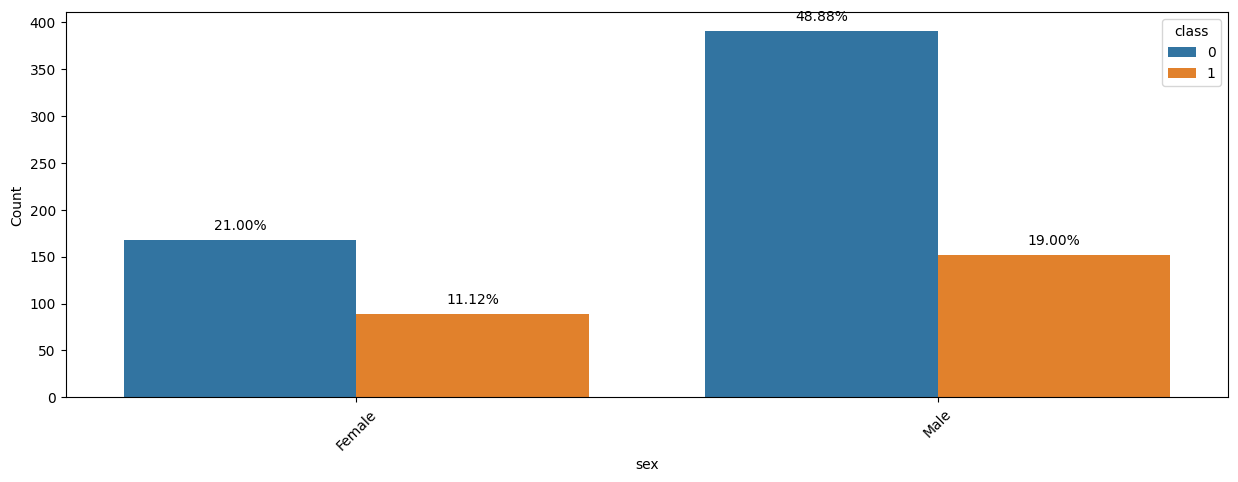

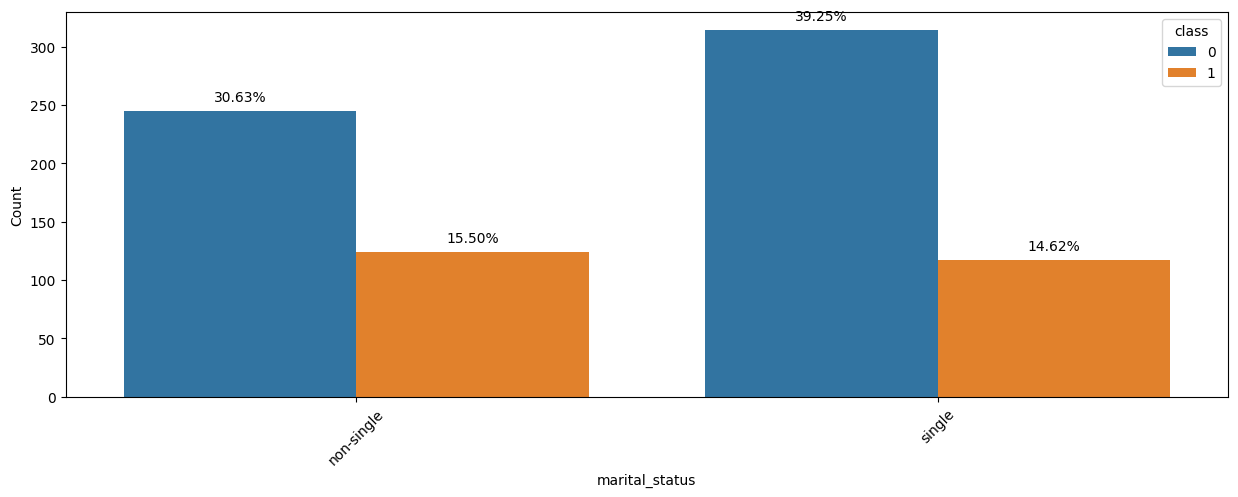

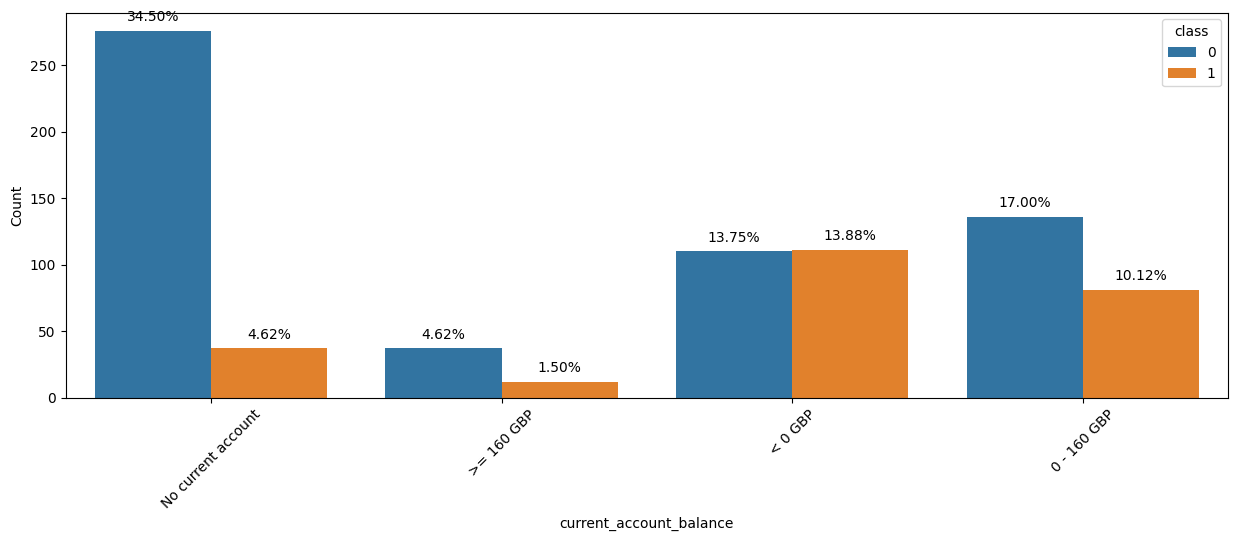

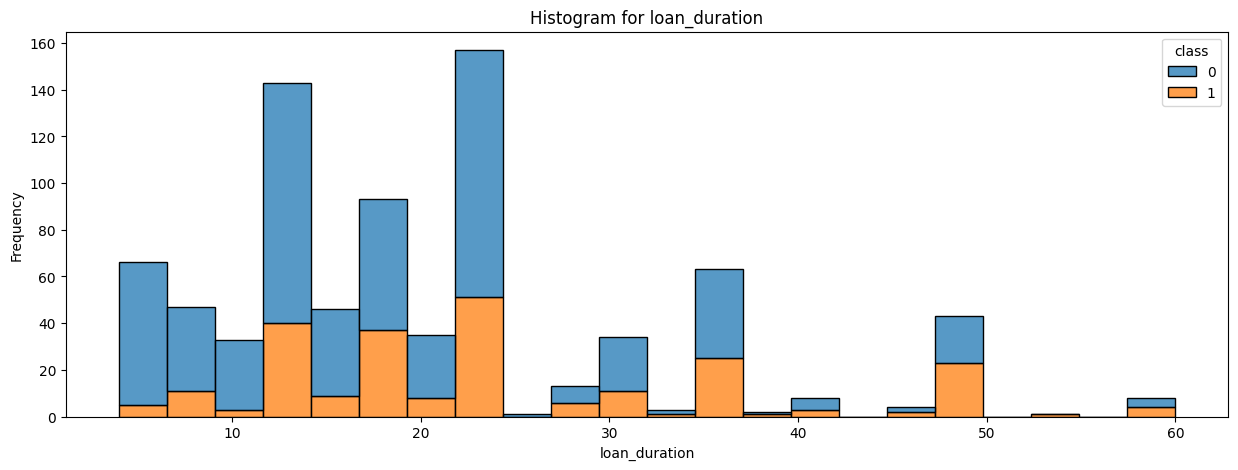

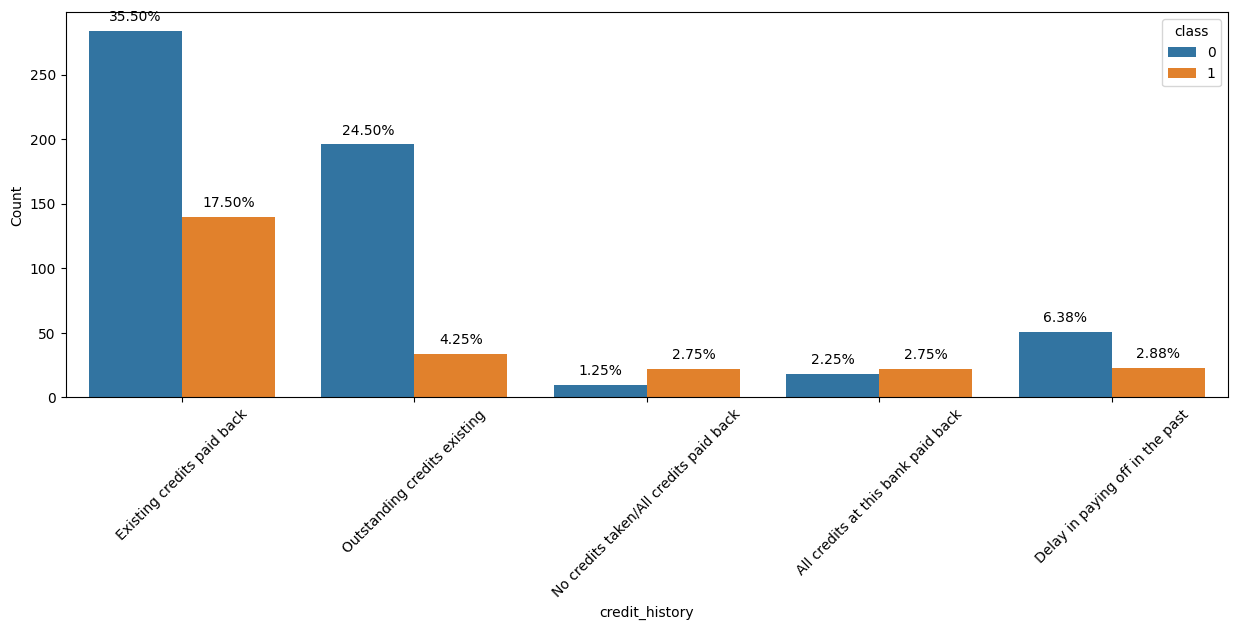

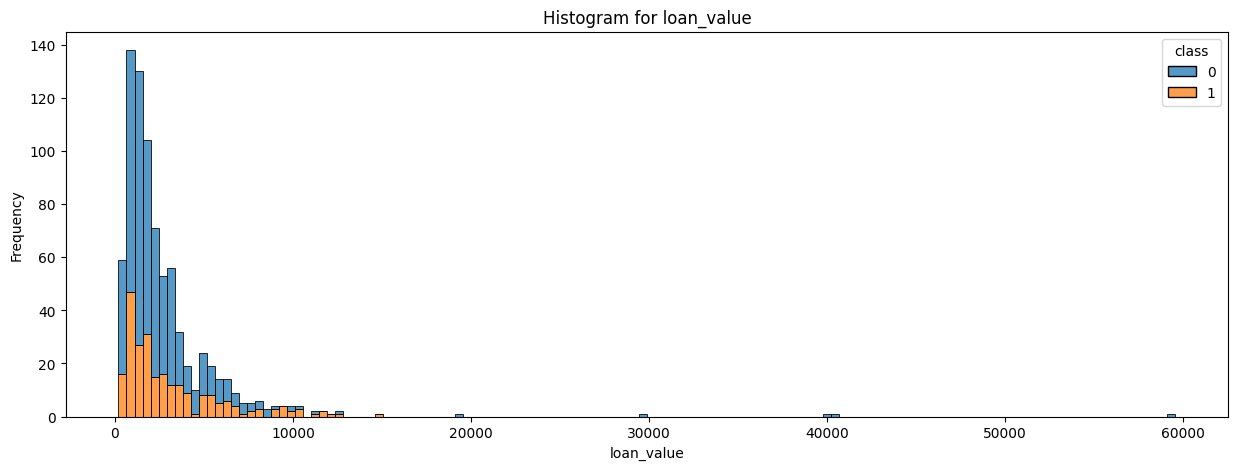

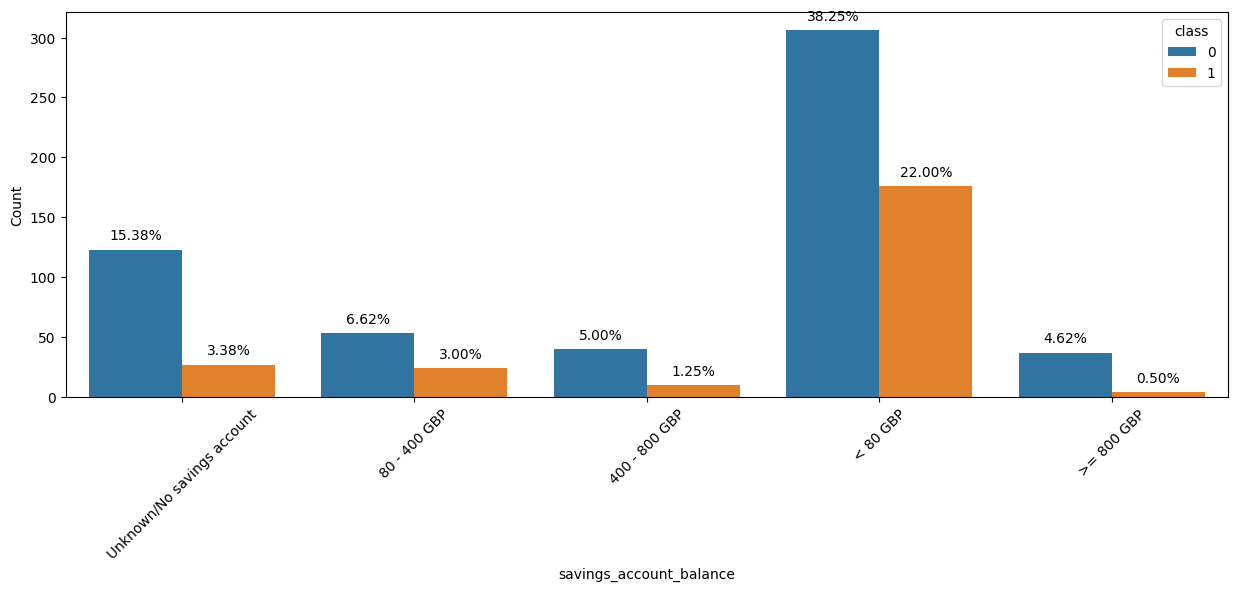

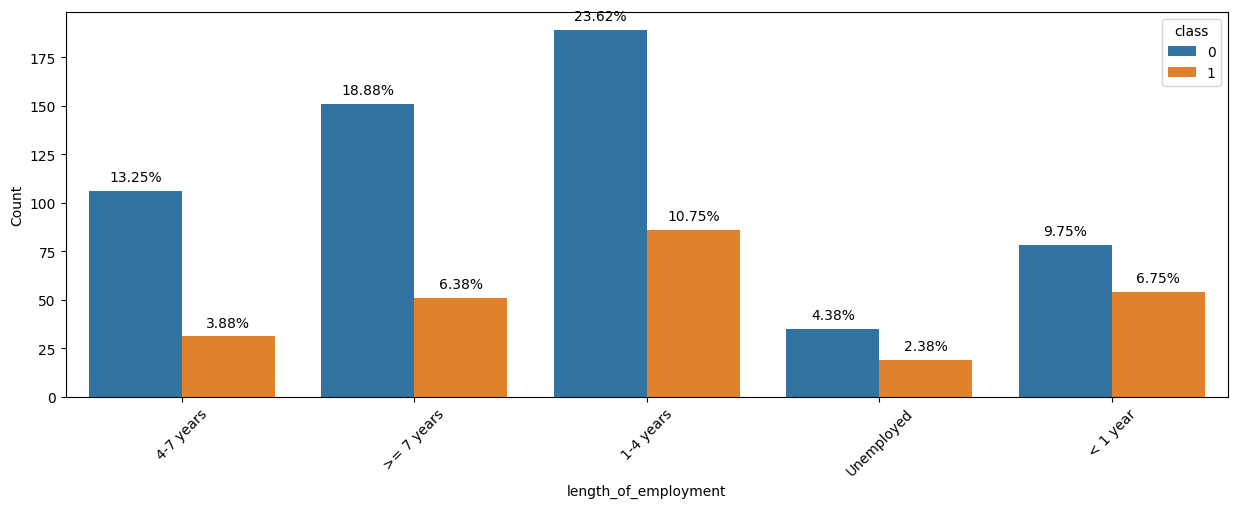

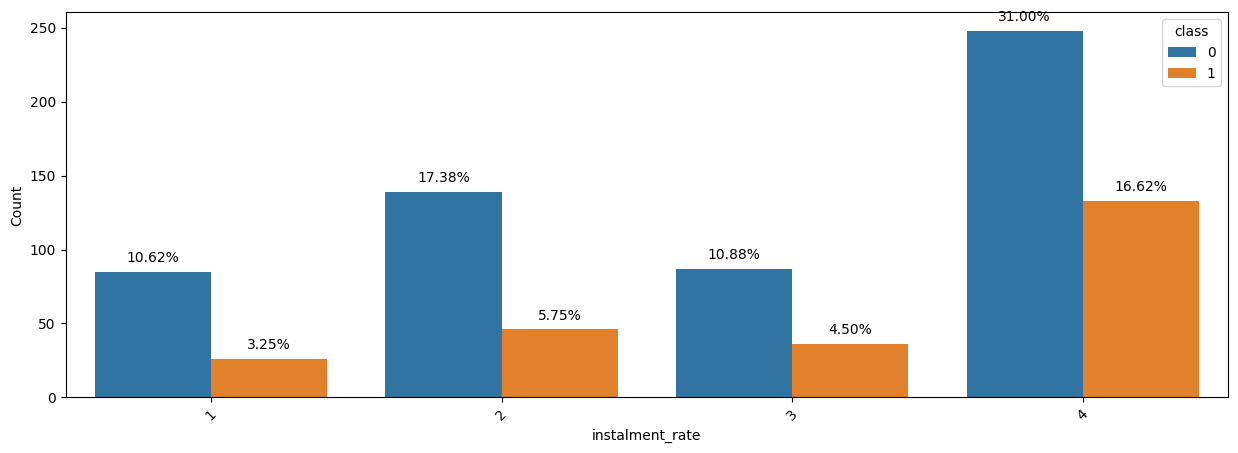

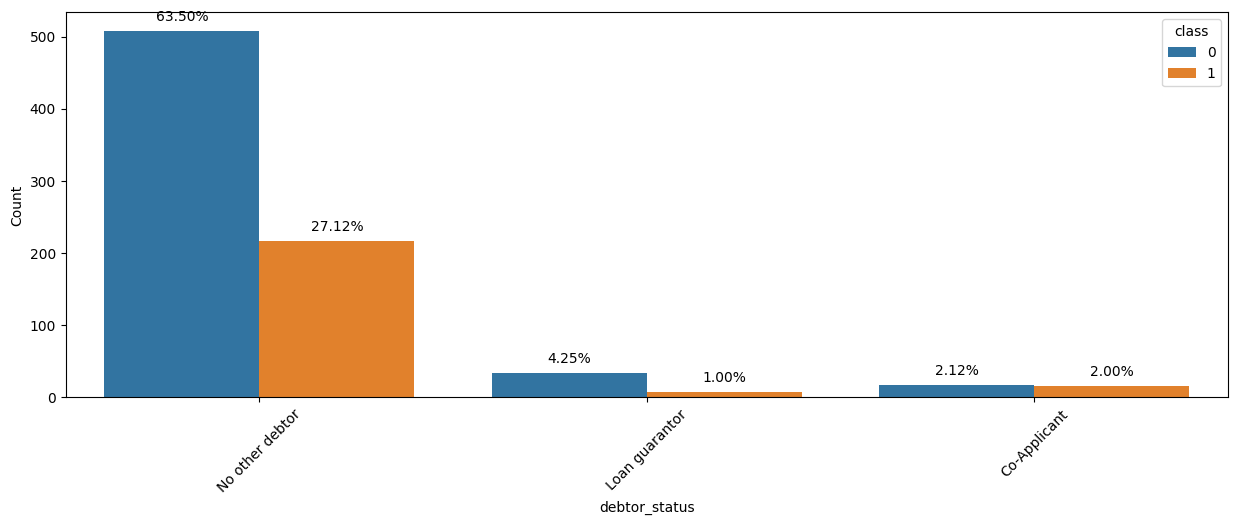

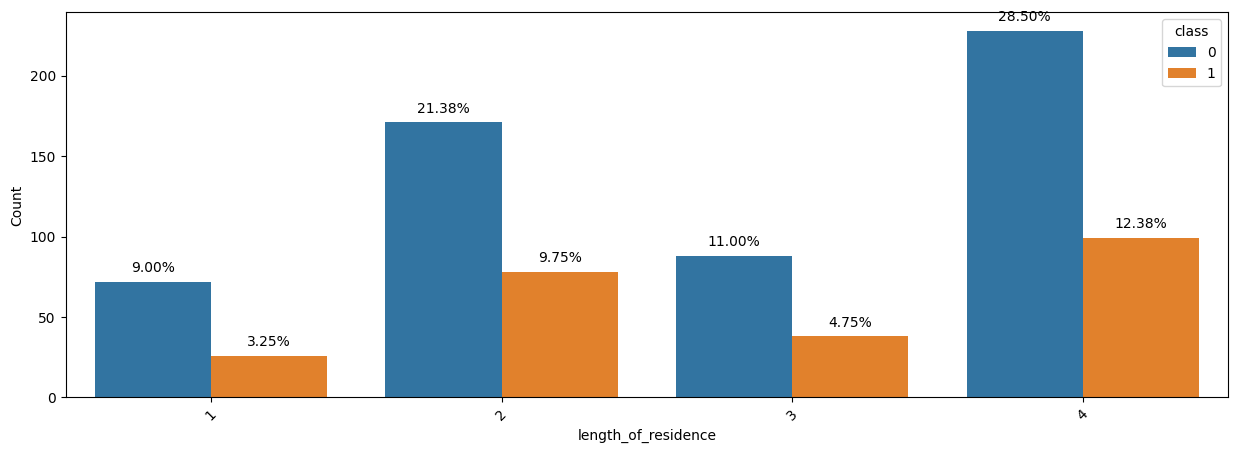

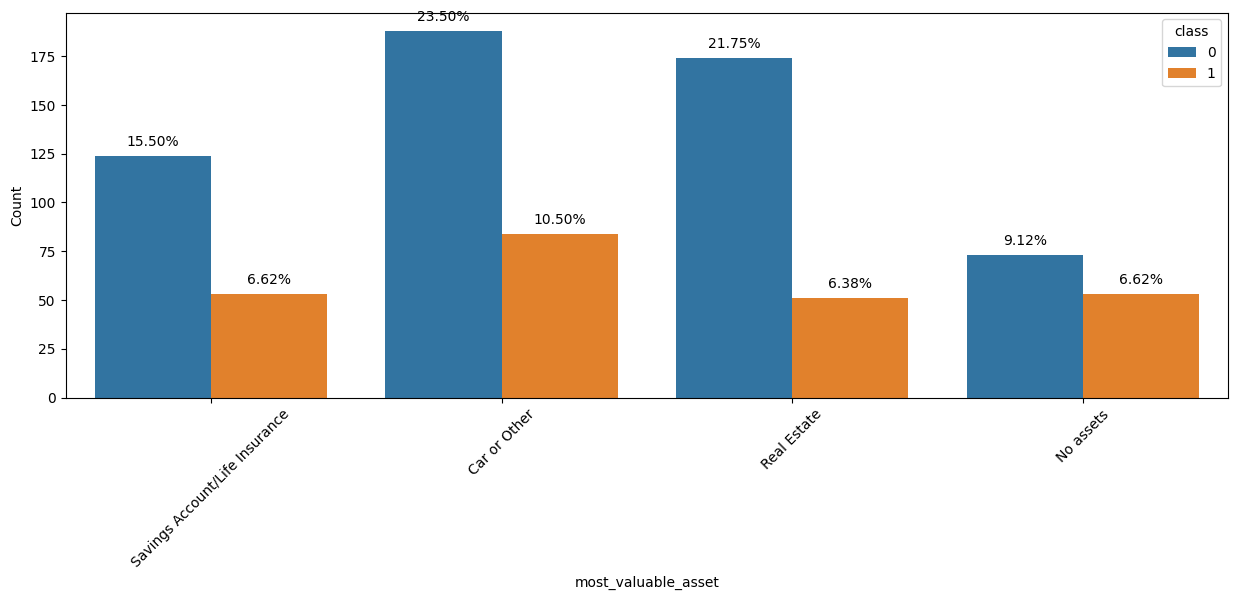

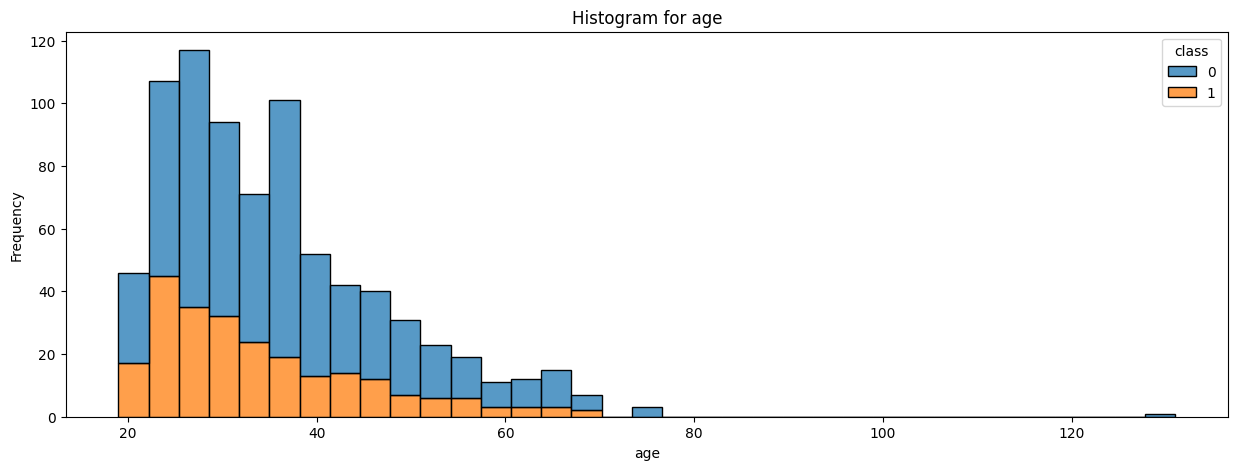

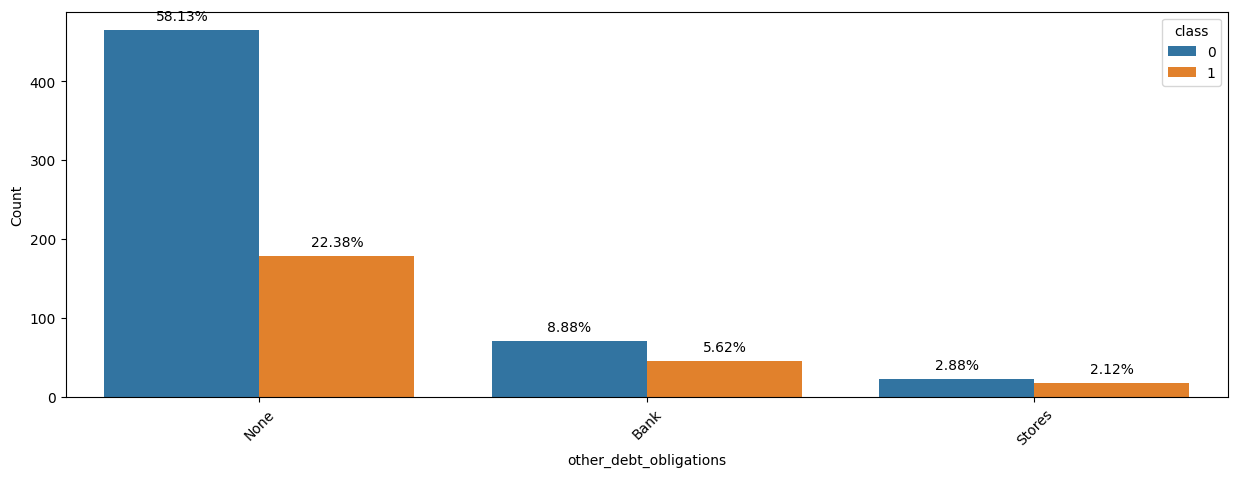

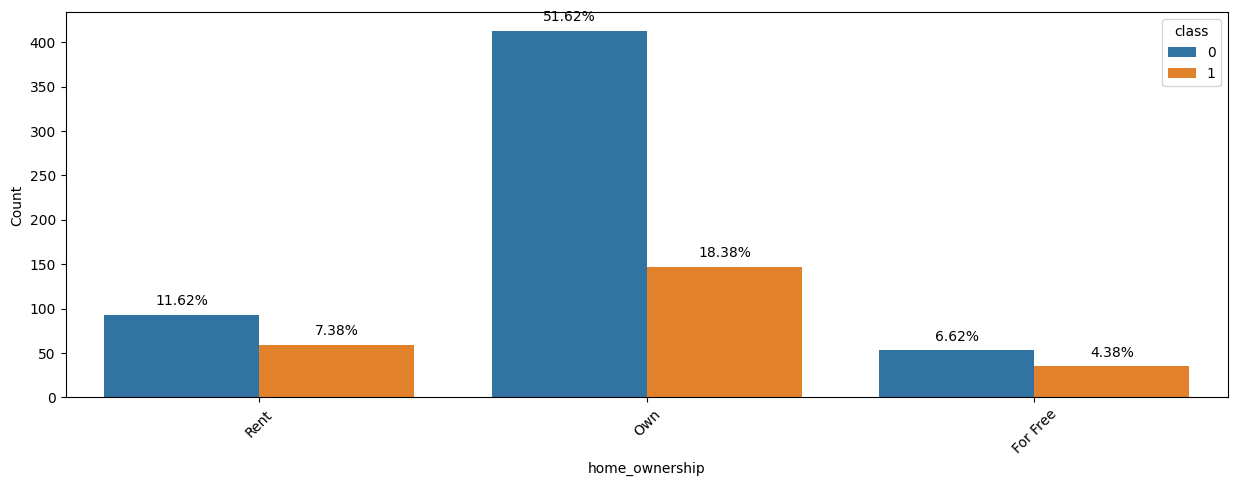

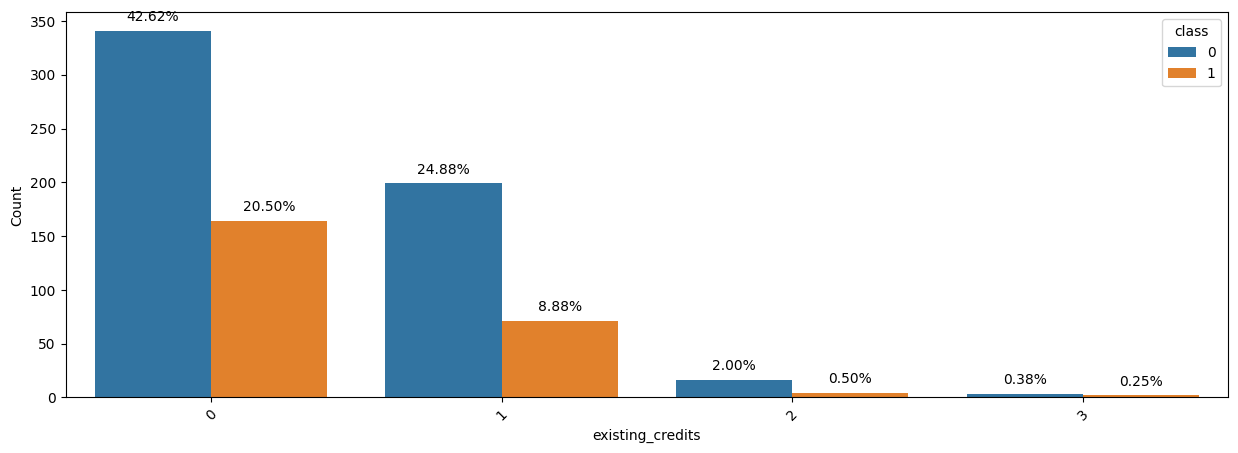

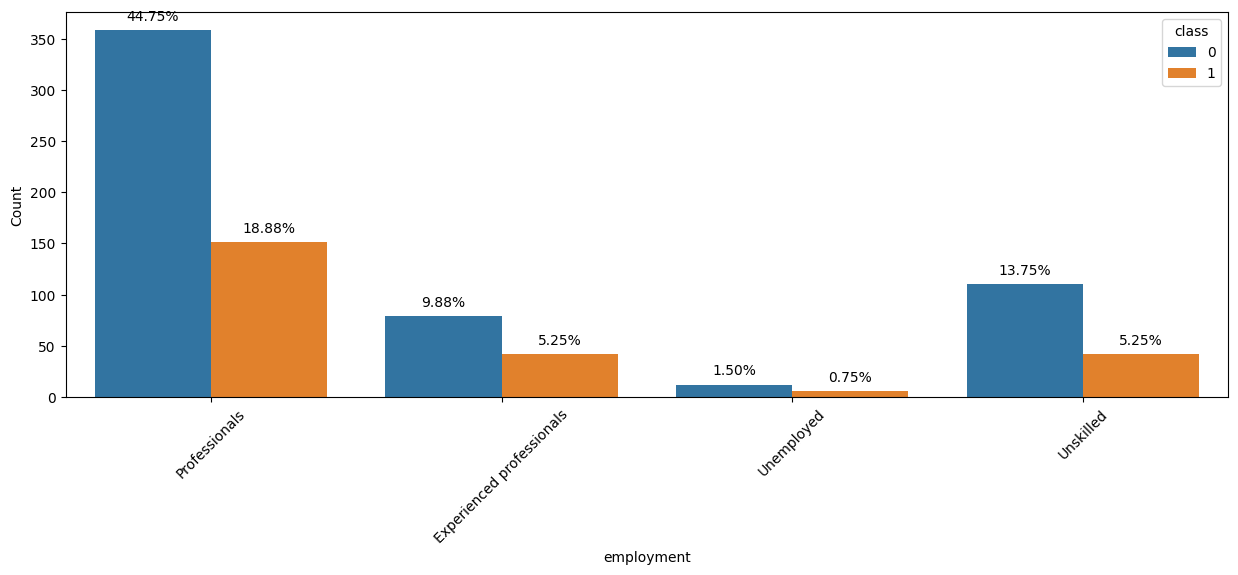

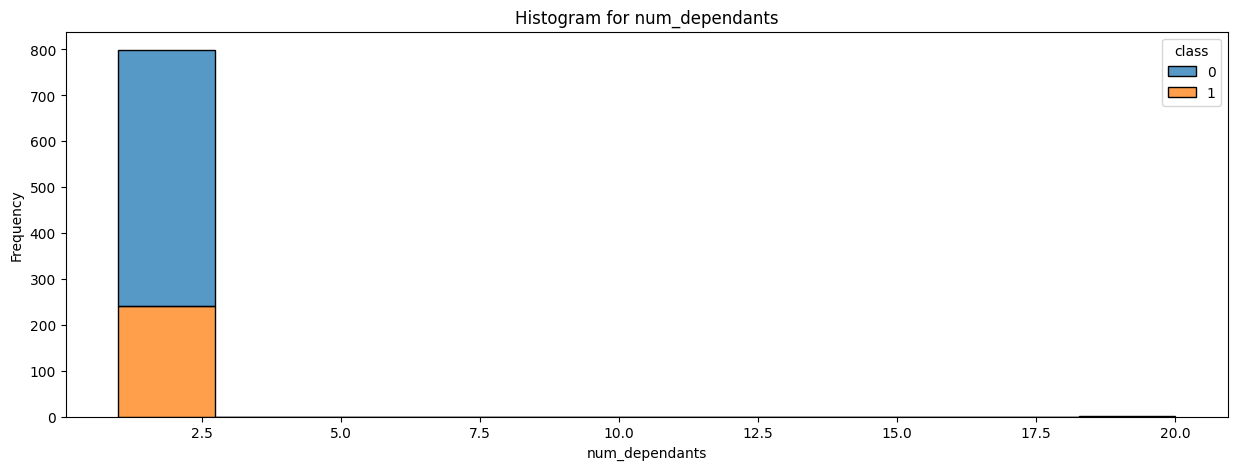

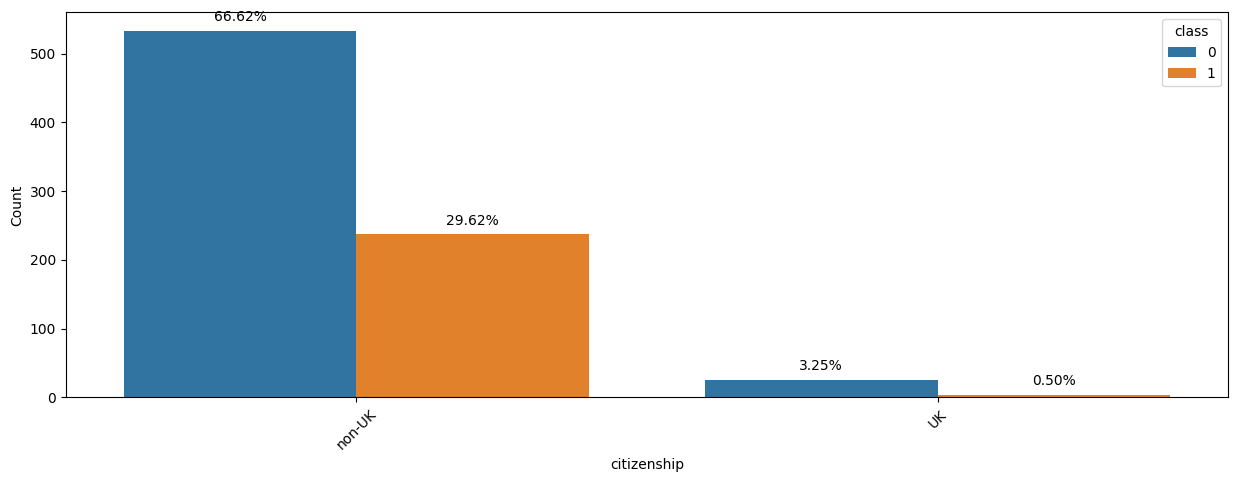

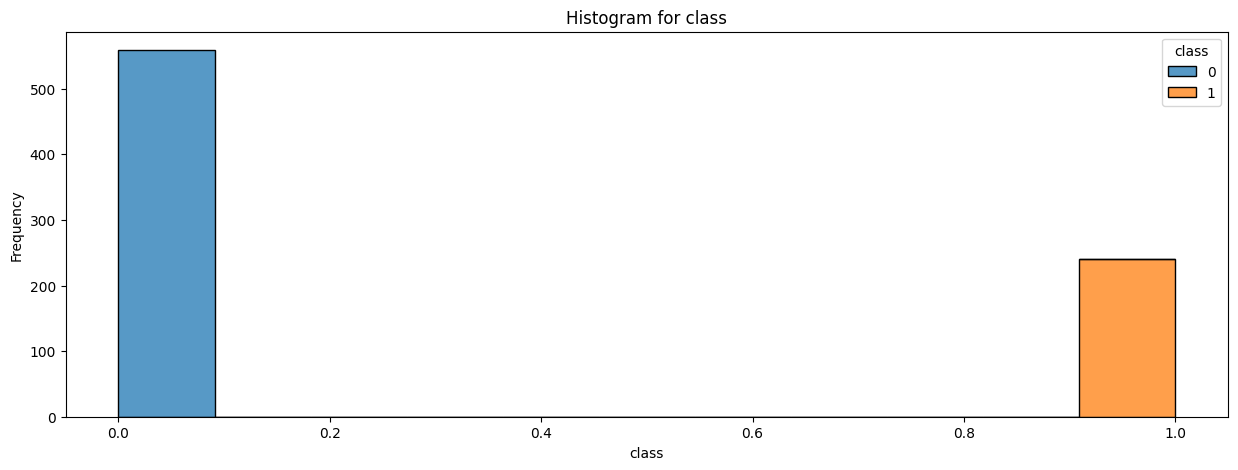

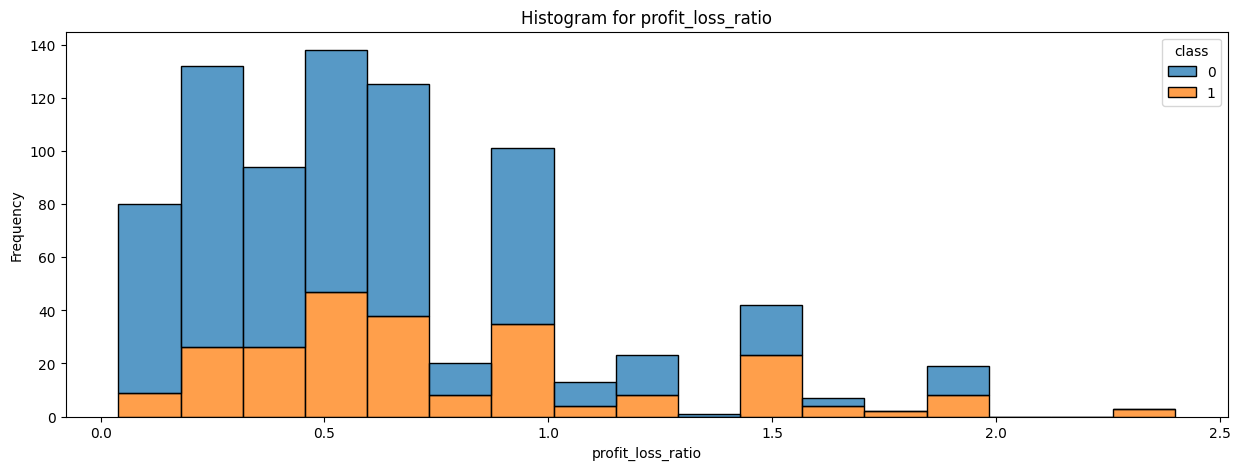

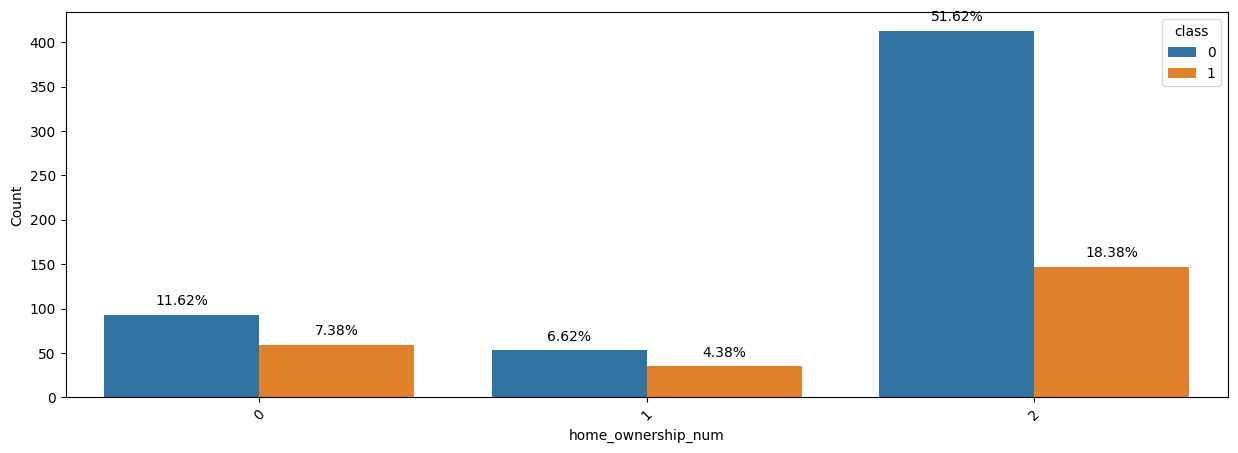

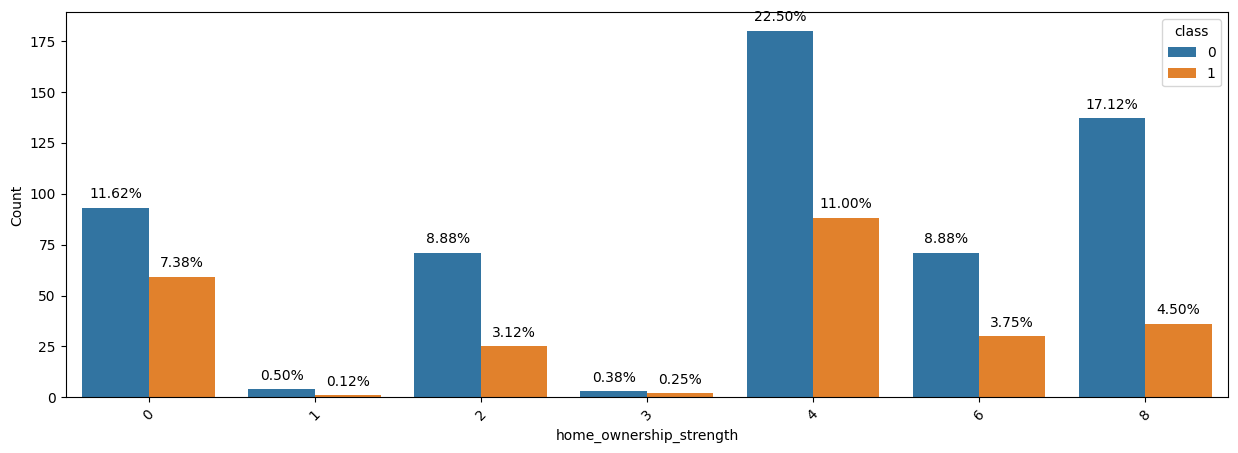

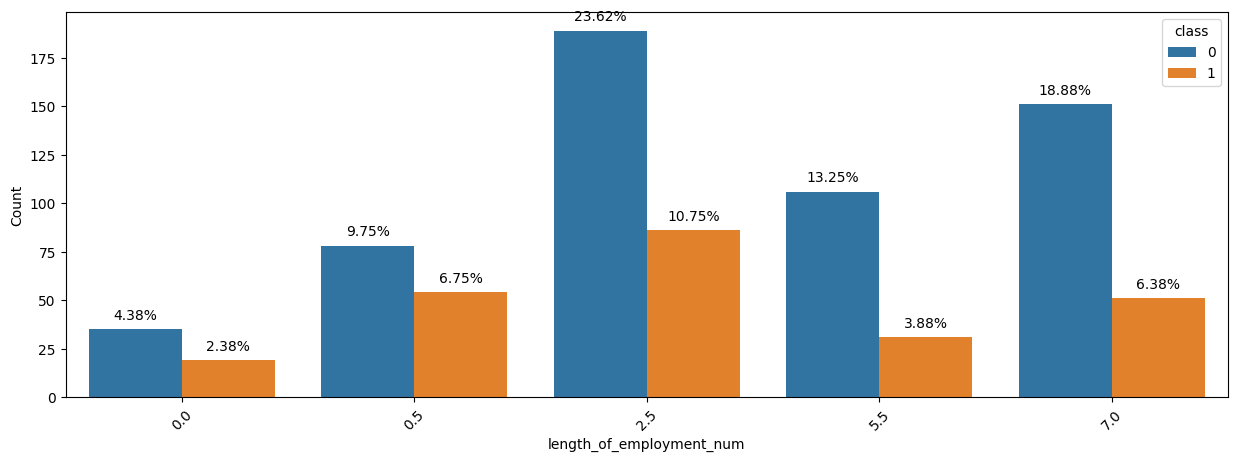

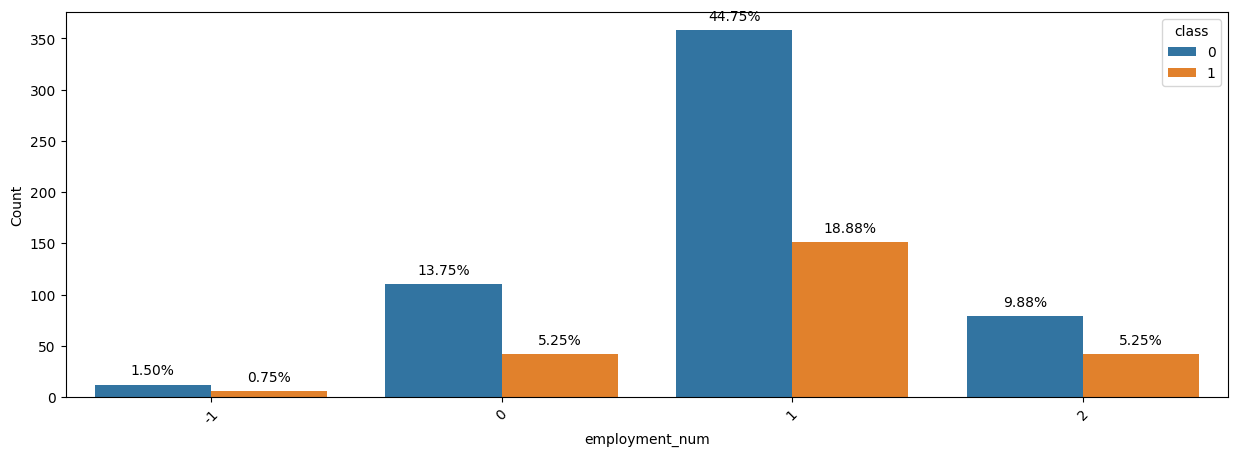

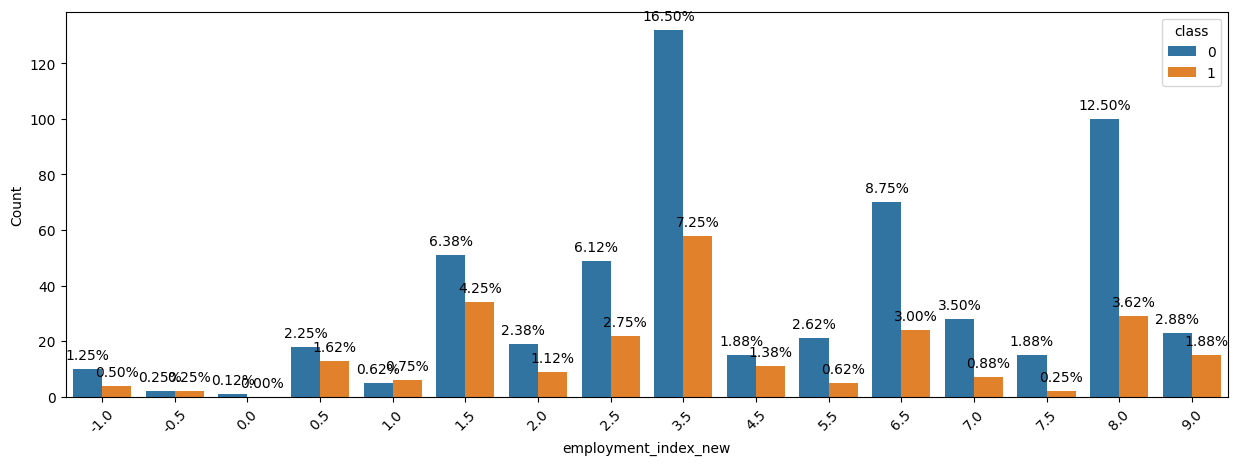

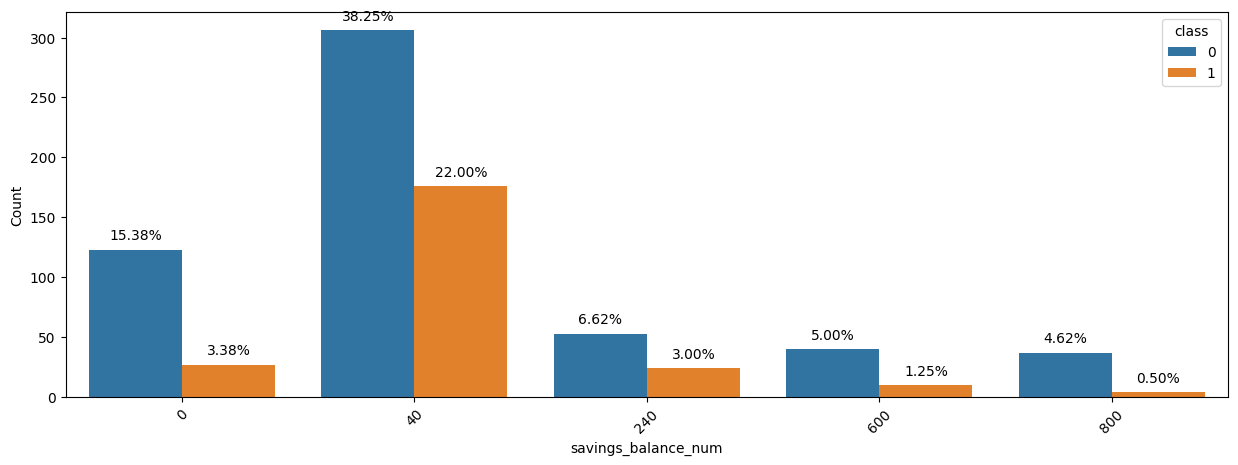

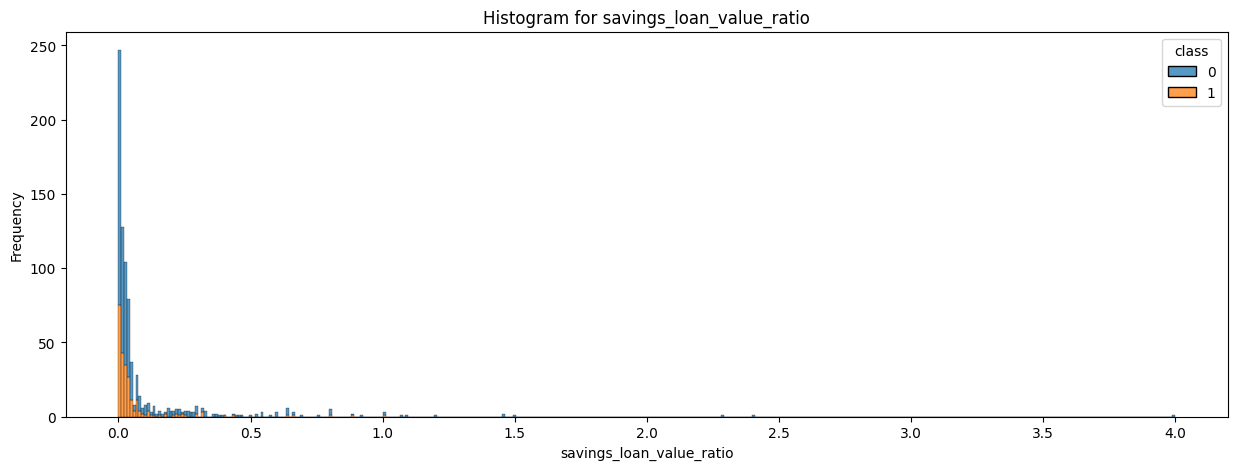

In [49]:
# Load the dataset
train_data = pd.read_csv('credit_data_train.csv')

# Identify and remove outliers based on domain knowledge or statistical rules
# For instance, if 'loan_value' has an outlier, we could remove it like this:

train_data = feature_engineer(train_data)

# Assuming df is your DataFrame
columns_to_convert = ['instalment_rate', 'length_of_residence', 'existing_credits', 'home_ownership_num', 'home_ownership_strength', 'length_of_employment_num', 'employment_num', 'employment_index_new', 'savings_balance_num']

# Convert specified columns to object data type
train_data[columns_to_convert] = train_data[columns_to_convert].astype('object')

visualize_data(train_data)

# Separate features and target from the training data
X = train_data.drop('class', axis=1)
y = train_data['class']

# Define numerical and categorical columns
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X.select_dtypes(include=['object', 'bool']).columns

In [50]:
train_data.head(10)

,sex,marital_status,current_account_balance,loan_duration,credit_history,loan_value,savings_account_balance,length_of_employment,instalment_rate,debtor_status,...,citizenship,class,profit_loss_ratio,home_ownership_num,home_ownership_strength,length_of_employment_num,employment_num,employment_index_new,savings_balance_num,savings_loan_value_ratio
0,Female,non-single,No current account,22,Existing credits paid back,1050.0,Unknown/No savings account,4-7 years,4,No other debtor,...,non-UK,0,0.88,0,0,5.5,1,6.5,0,0.000000
1,Male,single,No current account,12,Existing credits paid back,1900.0,Unknown/No savings account,>= 7 years,4,No other debtor,...,non-UK,0,0.48,2,6,7.0,1,8.0,0,0.000000
2,Female,non-single,>= 160 GBP,21,Existing credits paid back,2350.0,80 - 400 GBP,1-4 years,1,No other debtor,...,non-UK,0,0.21,2,2,2.5,2,4.5,240,0.102128
3,Female,non-single,< 0 GBP,6,Existing credits paid back,1100.0,400 - 800 GBP,Unemployed,1,No other debtor,...,non-UK,0,0.06,0,0,0.0,-1,-1.0,600,0.545455
4,Female,non-single,< 0 GBP,18,Existing credits paid back,2550.0,< 80 GBP,1-4 years,2,No other debtor,...,non-UK,1,0.36,2,4,2.5,1,3.5,40,0.015686
5,Female,non-single,No current account,24,Existing credits paid back,1100.0,400 - 800 GBP,4-7 years,4,No other debtor,...,non-UK,0,0.96,2,2,5.5,1,6.5,600,0.545455
6,Male,single,No current account,24,Existing credits paid back,2750.0,400 - 800 GBP,>= 7 years,3,No other debtor,...,non-UK,0,0.72,2,4,7.0,1,8.0,600,0.218182
7,Male,single,No current account,18,Outstanding credits existing,3100.0,< 80 GBP,4-7 years,3,No other debtor,...,non-UK,0,0.54,2,2,5.5,1,6.5,40,0.012903
8,Female,non-single,0 - 160 GBP,24,Outstanding credits existing,4600.0,< 80 GBP,< 1 year,2,No other debtor,...,non-UK,0,0.48,1,4,0.5,1,1.5,40,0.008696
9,Female,non-single,0 - 160 GBP,24,Existing credits paid back,3300.0,400 - 800 GBP,< 1 year,3,No other debtor,...,non-UK,1,0.72,0,0,0.5,1,1.5,600,0.181818


In [51]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 28 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   sex                       800 non-null    object 
 1   marital_status            800 non-null    object 
 2   current_account_balance   800 non-null    object 
 3   loan_duration             800 non-null    int64  
 4   credit_history            800 non-null    object 
 5   loan_value                800 non-null    float64
 6   savings_account_balance   800 non-null    object 
 7   length_of_employment      800 non-null    object 
 8   instalment_rate           800 non-null    object 
 9   debtor_status             800 non-null    object 
 10  length_of_residence       800 non-null    object 
 11  most_valuable_asset       800 non-null    object 
 12  age                       792 non-null    float64
 13  other_debt_obligations    800 non-null    object 
 14  home_owner

In [52]:
# Create the preprocessing pipelines for both numerical and categorical data
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine the numerical and categorical pipelines into one preprocessor
preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_transformer, numerical_cols),
    ('cat', categorical_transformer, categorical_cols)
])

# Apply preprocessing and feature engineering
# Fit the preprocessor and transform the training data
X_preprocessed = preprocessor.fit_transform(X)

In [53]:
# Apply binning to the numerical features
binning_age = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile')
binning_loan_duration = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='quantile')
binning_loan_value = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='quantile')

# Fit and transform the binned features
X_age_binned = binning_age.fit_transform(X_preprocessed[:, numerical_cols.get_loc('age')].reshape(-1, 1))
X_loan_duration_binned = binning_loan_duration.fit_transform(X_preprocessed[:, numerical_cols.get_loc('loan_duration')].reshape(-1, 1))
X_loan_value_binned = binning_loan_value.fit_transform(X_preprocessed[:, numerical_cols.get_loc('loan_value')].reshape(-1, 1))

# Replace the original features with the binned features
X_binned = np.copy(X_preprocessed)
X_binned[:, numerical_cols.get_loc('age')] = X_age_binned.ravel()
X_binned[:, numerical_cols.get_loc('loan_duration')] = X_loan_duration_binned.ravel()
X_binned[:, numerical_cols.get_loc('loan_value')] = X_loan_value_binned.ravel()

# Resample the training set to address class imbalance
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(X_binned, y)

TypeError: ignored

In [ ]:
# Define the model
model = ExtraTreesClassifier(random_state=0)

# Train the model on the resampled data
model.fit(X_resampled, y_resampled)

# Perform cross-validation to evaluate the model
cv_scores = cross_val_score(model, X_resampled, y_resampled, cv=5, scoring='accuracy')

In [ ]:
# Make predictions on the test set
# (Assuming the same preprocessing steps apply to the test set, including binning)
test_data = pd.read_csv('credit_data_test.csv')

test_data = feature_engineer(test_data)

test_data.head(5)

In [ ]:
X_test_preprocessed = preprocessor.transform(test_data)
# Apply the same binning to the test data
X_test_age_binned = binning_age.transform(X_test_preprocessed[:, numerical_cols.get_loc('age')].reshape(-1, 1))
X_test_loan_duration_binned = binning_loan_duration.transform(X_test_preprocessed[:, numerical_cols.get_loc('loan_duration')].reshape(-1, 1))
X_test_loan_value_binned = binning_loan_value.transform(X_test_preprocessed[:, numerical_cols.get_loc('loan_value')].reshape(-1, 1))
# Replace the original features with the binned features in the test data
X_test_binned = np.copy(X_test_preprocessed)
X_test_binned[:, numerical_cols.get_loc('age')] = X_test_age_binned.ravel()
X_test_binned[:, numerical_cols.get_loc('loan_duration')] = X_test_loan_duration_binned.ravel()
X_test_binned[:, numerical_cols.get_loc('loan_value')] = X_test_loan_value_binned.ravel()
# Predict on the binned test data
test_predictions = model.predict(X_test_binned)

# Output the predictions
output = pd.DataFrame({'id': test_data['id'], 'class': test_predictions})
output.to_csv('sample_submission_test.csv', index=False)
# output.to_csv('sample_submission_prfLssRt_noLnPrps_empStbl_svngLnRt_hmOwnStr.csv', index=False)

# Print the average cross-validation score
print(f'Average CV accuracy: {cv_scores.mean()}')